# 🎼 Music Generator
This notebook builds a complete deep learning-based music generator from scratch.
- Preprocess raw MIDI files
- Train LSTM and Transformer models
- Generate new music
- Save outputs as MIDI


## 📦 Install Dependencies

In [3]:
%pip install pretty_midi tensorflow numpy matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 📚 Imports

In [ ]:
import os
import numpy as np
import pretty_midi
import collections
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

## 🎹 Preprocess MIDI 

In [3]:
import os
import numpy as np
import pretty_midi
import collections
from glob import glob

# === Configuration ===
MIDI_FOLDER = "midi_input_music"
OUTPUT_FOLDER = "processed_data_transformer"
SEQ_LENGTH = 128
PITCH_VOCAB = 128
STEP_BINS = np.linspace(0, 1.0, 100)
DUR_BINS = np.linspace(0, 2.0, 100)
STEP_BIN_THRESHOLD = len(STEP_BINS) - 1
MAX_FILES = 100

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# === Quantization helper ===
def quantize(values, bins):
    return np.clip(np.digitize(values, bins) - 1, 0, len(bins) - 1)

# === Parse single MIDI into tokens, return matrix and instrument info ===
def midi_to_quantized_tokens(midi_file: str):
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        for instrument in pm.instruments:
            if instrument.is_drum or not instrument.notes:
                continue

            notes = sorted(instrument.notes, key=lambda note: note.start)
            if len(notes) <= SEQ_LENGTH:
                continue

            tokens = collections.defaultdict(list)
            prev_start = notes[0].start

            for note in notes:
                start = note.start
                end = note.end
                step = start - prev_start
                duration = end - start
                if step < 0 or duration <= 0:
                    continue
                tokens["pitch"].append(note.pitch)
                tokens["step"].append(step)
                tokens["duration"].append(duration)
                prev_start = start

            pitch = np.array(tokens["pitch"])
            step = quantize(tokens["step"], STEP_BINS)
            duration = quantize(tokens["duration"], DUR_BINS)

            valid = step <= STEP_BIN_THRESHOLD
            if not np.any(valid):
                return None, None

            pitch = pitch[valid]
            step = step[valid]
            duration = duration[valid]

            if len(pitch) <= SEQ_LENGTH:
                return None, None

            token_matrix = np.stack([pitch, step, duration], axis=1)
            return token_matrix, instrument.program

    except Exception as e:
        print(f"❌ Error parsing {midi_file}: {e}")
        return None, None

# === Find all MIDI files recursively ===
all_midi_files = sorted(glob(os.path.join(MIDI_FOLDER, "**", "*.mid"), recursive=True))
all_midi_files += sorted(glob(os.path.join(MIDI_FOLDER, "**", "*.midi"), recursive=True))

# === Process all MIDI files ===
saved = 0
for i, filepath in enumerate(all_midi_files):
    if saved >= MAX_FILES:
        break

    filename = os.path.splitext(os.path.basename(filepath))[0]
    token_matrix, program = midi_to_quantized_tokens(filepath)
    if token_matrix is None or len(token_matrix) <= SEQ_LENGTH:
        print(f"⚠️ Skipping {filepath}: too few valid notes.")
        continue

    X, y = [], []
    for j in range(len(token_matrix) - SEQ_LENGTH):
        X.append(token_matrix[j:j + SEQ_LENGTH])
        y.append(token_matrix[j + SEQ_LENGTH])

    if not X:
        continue

    song_id = i
    output_path = os.path.join(OUTPUT_FOLDER, f"{filename}.npz")
    np.savez_compressed(
        output_path,
        X=np.array(X),
        y=np.array(y),
        program=program,
        song_id=song_id,
        filename=filename
    )
    print(f"✅ Saved {filename}: {len(X)} sequences → {output_path}")
    saved += 1

print(f"\n🎉 Done! Saved {saved} files to {OUTPUT_FOLDER}")


C:\Users\andreea.asimine\AppData\Roaming\Python\Python312\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


✅ Saved A_Campfire_Song: 722 sequences → processed_data_transformer\A_Campfire_Song.npz
✅ Saved Theme_From_The_Godfather: 364 sequences → processed_data_transformer\Theme_From_The_Godfather.npz
✅ Saved Dreadlock_Holiday.1: 2817 sequences → processed_data_transformer\Dreadlock_Holiday.1.npz
✅ Saved Dreadlock_Holiday.2: 285 sequences → processed_data_transformer\Dreadlock_Holiday.2.npz
✅ Saved Dreadlock_Holiday.3: 2723 sequences → processed_data_transformer\Dreadlock_Holiday.3.npz
❌ Error parsing midi_input_music\10cc\Dreadlock_Holiday.4.mid: data byte must be in range 0..127
⚠️ Skipping midi_input_music\10cc\Dreadlock_Holiday.4.mid: too few valid notes.
✅ Saved Dreadlock_Holiday: 345 sequences → processed_data_transformer\Dreadlock_Holiday.npz
✅ Saved Im_Not_In_Love.1: 1306 sequences → processed_data_transformer\Im_Not_In_Love.1.npz
✅ Saved Im_Not_In_Love.2: 299 sequences → processed_data_transformer\Im_Not_In_Love.2.npz
✅ Saved Im_Not_In_Love.3: 1306 sequences → processed_data_transfor

## 🧠 Build Transformer Model

✅ Loaded dataset: 80500 training sequences


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step_in             │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │     16,384 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 128, 128)  │     12,800 │ step_in[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_in         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128)  │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 128, 128)  │     12,800 │ duration_in[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_in (InputLayer) │ (None, 128)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128)  │          0 │ add[0][0],        │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 128, 128)  │     16,384 │ pos_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 128)  │          0 │ add_1[0][0],      │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    263,808 │ add_2[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 128)  │          0 │ add_2[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 128)  │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128)  │    131,712 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 128, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 893,000 (3.41 MB)

 Trainable params: 893,000 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - duration_accuracy: 0.5243 - duration_loss: 1.8048 - loss: 3.5254 - pitch_accuracy: 0.3017 - pitch_loss: 2.7183 - step_accuracy: 0.7148 - step_loss: 1.1770
Epoch 1: val_loss improved from inf to 5.44794, saving model to checkpoints/transformer_music_best.keras
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 380s 298ms/step - duration_accuracy: 0.5244 - duration_loss: 1.8045 - loss: 3.5247 - pitch_accuracy: 0.3018 - pitch_loss: 2.7179 - step_accuracy: 0.7149 - step_loss: 1.1767 - val_duration_accuracy: 0.3345 - val_duration_loss: 2.6480 - val_loss: 5.4479 - val_pitch_accuracy: 0.2806 - val_pitch_loss: 2.8462 - val_step_accuracy: 0.5251 - val_step_loss: 2.2376
Epoch 2/30
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - duration_accuracy: 0.7490 - duration_loss: 0.8874 - loss: 1.6369 - pitch_accuracy: 0.5765 - pitch_loss: 1.4539 - step_accuracy: 0.8665 - step_loss: 0.4587
Epoch 2: val_loss did not improve from 5.44794
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 44

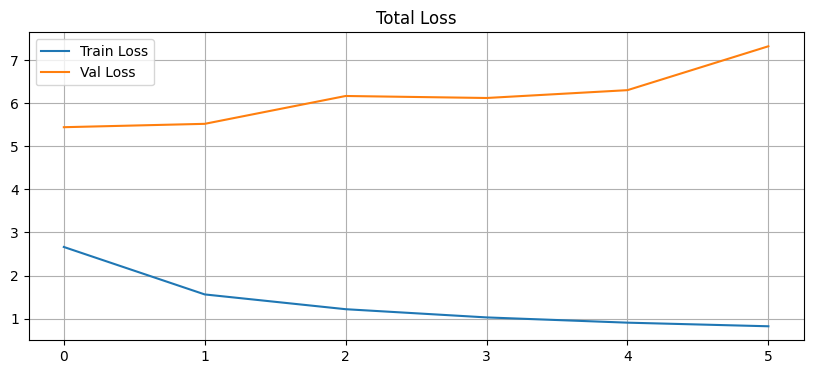

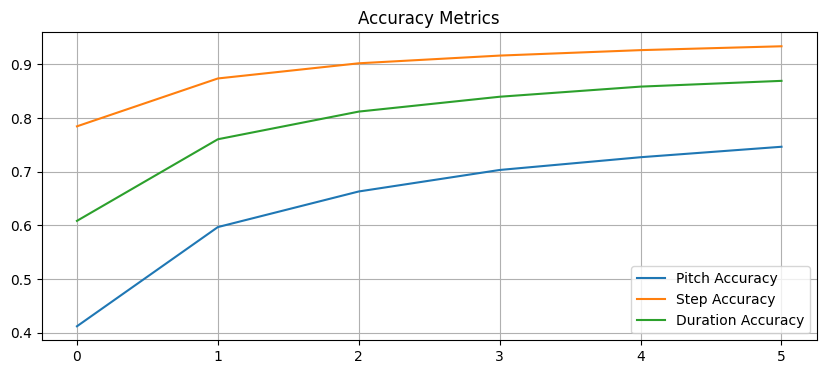

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# === Configuration ===
DATA_FOLDER = "processed_data_transformer"
PITCH_VOCAB = 128
STEP_VOCAB = 100
DUR_VOCAB = 100
D_MODEL = 128
SEQ_LEN = 128
EPOCHS = 30
BATCH_SIZE = 64

# === Load all .npz files ===
all_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith(".npz")]
train_files, val_files = train_test_split(all_files, test_size=0.1, random_state=42)

def load_dataset(file_list):
    X_all, y_all = [], []
    for f in file_list:
        data = np.load(os.path.join(DATA_FOLDER, f))
        X_all.append(data['X'])
        y_all.append(data['y'])
    X = np.concatenate(X_all)
    y = np.concatenate(y_all)
    pos = np.tile(np.arange(X.shape[1]), (X.shape[0], 1))  # positional indices
    return [X[:, :, 0].astype(int), X[:, :, 1].astype(int), X[:, :, 2].astype(int), pos], {
        "pitch": y[:, 0].astype(int),
        "step": y[:, 1].astype(int),
        "duration": y[:, 2].astype(int)
    }

X_train, y_train = load_dataset(train_files)
X_val, y_val = load_dataset(val_files)

print(f"✅ Loaded dataset: {len(X_train[0])} training sequences")

# === Transformer block ===
def transformer_block(x, d_model, num_heads, dropout=0.1):
    attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout)(x, x)
    x = tf.keras.layers.LayerNormalization()(x + attn)
    ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(d_model * 4, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(d_model)
    ])(x)
    return tf.keras.layers.LayerNormalization()(x + ffn)

# === Build model ===
def build_model(seq_len, d_model=128, heads=4, layers=2, dropout=0.1):
    pitch_in = tf.keras.Input(shape=(seq_len,), name="pitch_in")
    step_in = tf.keras.Input(shape=(seq_len,), name="step_in")
    dur_in = tf.keras.Input(shape=(seq_len,), name="duration_in")
    pos_in = tf.keras.Input(shape=(seq_len,), name="pos_in")

    pitch_emb = tf.keras.layers.Embedding(PITCH_VOCAB, d_model)(pitch_in)
    step_emb = tf.keras.layers.Embedding(STEP_VOCAB, d_model)(step_in)
    dur_emb = tf.keras.layers.Embedding(DUR_VOCAB, d_model)(dur_in)
    pos_emb = tf.keras.layers.Embedding(seq_len, d_model)(pos_in)

    x = pitch_emb + step_emb + dur_emb + pos_emb

    for _ in range(layers):
        x = transformer_block(x, d_model, heads, dropout)

    x = tf.keras.layers.LayerNormalization()(x)
    x = x[:, -1]  # Final timestep only

    pitch_out = tf.keras.layers.Dense(PITCH_VOCAB, activation="softmax", name="pitch")(x)
    step_out = tf.keras.layers.Dense(STEP_VOCAB, activation="softmax", name="step")(x)
    dur_out = tf.keras.layers.Dense(DUR_VOCAB, activation="softmax", name="duration")(x)

    return tf.keras.Model(
        inputs=[pitch_in, step_in, dur_in, pos_in],
        outputs={"pitch": pitch_out, "step": step_out, "duration": dur_out}
    )

# === Compile model ===
model = build_model(SEQ_LEN, d_model=D_MODEL, heads=4, layers=2, dropout=0.1)

model.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    loss={
        "pitch": "sparse_categorical_crossentropy",
        "step": "sparse_categorical_crossentropy",
        "duration": "sparse_categorical_crossentropy"
    },
    loss_weights={"pitch": 0.2, "step": 1.0, "duration": 1.0},
    metrics={"pitch": "accuracy", "step": "accuracy", "duration": "accuracy"}
)

model.summary()

# === Callbacks ===
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("trained_model", exist_ok=True)

checkpoint = ModelCheckpoint(
    "checkpoints/transformer_music_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# === Train ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# === Save final model ===
model.save("trained_model/transformer_music_final.keras")
print("✅ Final model saved to 'trained_model/transformer_music_final.keras'")

# === Plot ===
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Total Loss")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history["pitch_accuracy"], label="Pitch Accuracy")
plt.plot(history.history["step_accuracy"], label="Step Accuracy")
plt.plot(history.history["duration_accuracy"], label="Duration Accuracy")
plt.title("Accuracy Metrics")
plt.legend(); plt.grid(); plt.show()


## 🎶 Generate New Music Using Transformer Model

In [4]:
import os
import numpy as np
import tensorflow as tf
import pretty_midi
import random
from glob import glob

# === Configuration ===
MODEL_PATH = "trained_model/transformer_music_final.keras"
DATA_FOLDER = "processed_data_transformer"
MIDI_FOLDER = "midi_input_music"
OUTPUT_FOLDER = "generated_music"
GENERATE_STEPS = 120
TEMPERATURE = 1.0
STEP_BINS = np.linspace(0, 1.0, 100)
DUR_BINS = np.linspace(0, 2.0, 100)

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
random.seed(42)
np.random.seed(42)

# === Load model ===
model = tf.keras.models.load_model(MODEL_PATH)
SEQ_LEN = model.input_shape[0][1]
print(f"✅ Loaded Transformer model. Sequence length = {SEQ_LEN}")

# === Sampling with temperature ===
def sample_with_temperature(probabilities, temperature=1.0):
    logits = np.log(probabilities + 1e-9) / temperature
    exp = np.exp(logits)
    probs = exp / np.sum(exp)
    return np.random.choice(len(probs), p=probs)

# === Convert bin index to real value ===
def bin_to_value(index, bins):
    index = np.clip(index, 0, len(bins) - 1)
    return bins[index]

# === Save notes as MIDI file ===
def save_to_midi(events, output_path, program=0):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    time = 0.0
    for pitch, step_bin, dur_bin in events:
        step = bin_to_value(step_bin, STEP_BINS)
        duration = bin_to_value(dur_bin, DUR_BINS)
        start = time + step
        end = start + duration
        note = pretty_midi.Note(
            velocity=100,
            pitch=int(pitch),
            start=start,
            end=end
        )
        instrument.notes.append(note)
        time = start

    pm.instruments.append(instrument)
    pm.write(output_path)
    print(f"🎵 Saved MIDI: {output_path}")

# === Generate new sequence using model ===
def generate_sequence(seed_tokens, model, steps=GENERATE_STEPS, temperature=TEMPERATURE):
    generated = []
    seed_pitch, seed_step, seed_dur = seed_tokens[:, 0], seed_tokens[:, 1], seed_tokens[:, 2]

    for _ in range(steps):
        pos = np.arange(len(seed_pitch)).reshape(1, -1)
        inputs = [
            seed_pitch.reshape(1, -1),
            seed_step.reshape(1, -1),
            seed_dur.reshape(1, -1),
            pos
        ]

        preds = model.predict(inputs, verbose=0)
        pitch = sample_with_temperature(preds["pitch"][0], temperature)
        step = sample_with_temperature(preds["step"][0], temperature)
        dur = sample_with_temperature(preds["duration"][0], temperature)

        generated.append((pitch, step, dur))

        # Slide window
        seed_pitch = np.roll(seed_pitch, -1)
        seed_step = np.roll(seed_step, -1)
        seed_dur = np.roll(seed_dur, -1)
        seed_pitch[-1] = pitch
        seed_step[-1] = step
        seed_dur[-1] = dur

    return generated

# === Gather all MIDI paths from input folder recursively ===
all_midi_paths = {os.path.splitext(os.path.basename(p))[0]: p for p in glob(os.path.join(MIDI_FOLDER, "**", "*.mid"), recursive=True)}

# === Main generation loop ===
for npz_file in sorted(os.listdir(DATA_FOLDER)):
    if not npz_file.endswith(".npz"):
        continue

    song_name = os.path.splitext(npz_file)[0]
    npz_path = os.path.join(DATA_FOLDER, npz_file)
    midi_path = all_midi_paths.get(song_name)

    if midi_path is None or not os.path.exists(midi_path):
        print(f"⚠️ Skipping {song_name}: original MIDI file not found.")
        continue

    data = np.load(npz_path)
    X = data["X"]
    program = int(data["program"]) if "program" in data else 0

    if len(X) < SEQ_LEN:
        print(f"⚠️ Skipping {npz_file}: not enough sequences.")
        continue

    seed = X[-1]
    seed_tokens = seed[:, :3].astype(int)

    print(f"🎶 Generating music in the style of: {song_name}")
    events = generate_sequence(seed_tokens, model)

    output_path = os.path.join(OUTPUT_FOLDER, f"{song_name}_Transformer.mid")
    save_to_midi(events, output_path, program=program)


✅ Loaded Transformer model. Sequence length = 128
⚠️ Skipping ..._Baby_One_More_Time: original MIDI file not found.
🎶 Generating music in the style of: A_Big_Hunk_O_Love
🎵 Saved MIDI: generated_music\A_Big_Hunk_O_Love_Transformer.mid
🎶 Generating music in the style of: A_Campfire_Song
🎵 Saved MIDI: generated_music\A_Campfire_Song_Transformer.mid
🎶 Generating music in the style of: All_Mixed_Up.1
🎵 Saved MIDI: generated_music\All_Mixed_Up.1_Transformer.mid
🎶 Generating music in the style of: All_Mixed_Up
🎵 Saved MIDI: generated_music\All_Mixed_Up_Transformer.mid
🎶 Generating music in the style of: Andra_tutto_bene_58_.1
🎵 Saved MIDI: generated_music\Andra_tutto_bene_58_.1_Transformer.mid
🎶 Generating music in the style of: Andra_tutto_bene_58_
🎵 Saved MIDI: generated_music\Andra_tutto_bene_58__Transformer.mid
⚠️ Skipping Bad_Meets_Evil.npz: not enough sequences.
🎶 Generating music in the style of: Because_You_Loved_Me
🎵 Saved MIDI: generated_music\Because_You_Loved_Me_Transformer.mid
🎶 

## 💾 Build LSTM Model

✅ Combined: X = (87272, 128, 3), y = (87272, 3)


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128, 256)  │    266,240 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128, 256)  │          0 │ lstm[0][0]        │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 100)       │     25,700 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     32,896 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 100)       │     25,700 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 875,848 (3.34 MB)

 Trainable params: 875,848 (3.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - duration_accuracy: 0.2628 - duration_loss: 2.6504 - loss: 8.0160 - pitch_accuracy: 0.1303 - pitch_loss: 3.2149 - step_accuracy: 0.4789 - step_loss: 2.1507
Epoch 1: val_loss improved from inf to 5.52824, saving model to checkpoints/lstm_model_best.keras
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 842s 684ms/step - duration_accuracy: 0.2629 - duration_loss: 2.6502 - loss: 8.0152 - pitch_accuracy: 0.1304 - pitch_loss: 3.2146 - step_accuracy: 0.4789 - step_loss: 2.1504 - val_duration_accuracy: 0.4032 - val_duration_loss: 1.9809 - val_loss: 5.5282 - val_pitch_accuracy: 0.2664 - val_pitch_loss: 2.3611 - val_step_accuracy: 0.6704 - val_step_loss: 1.1830
Epoch 2/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - duration_accuracy: 0.4077 - duration_loss: 1.9970 - loss: 5.5352 - pitch_accuracy: 0.2555 - pitch_loss: 2.3693 - step_accuracy: 0.6699 - step_loss: 1.1689
Epoch 2: val_loss improved from 5.52824 to 4.57006, saving model to checkpoints/lstm_mo

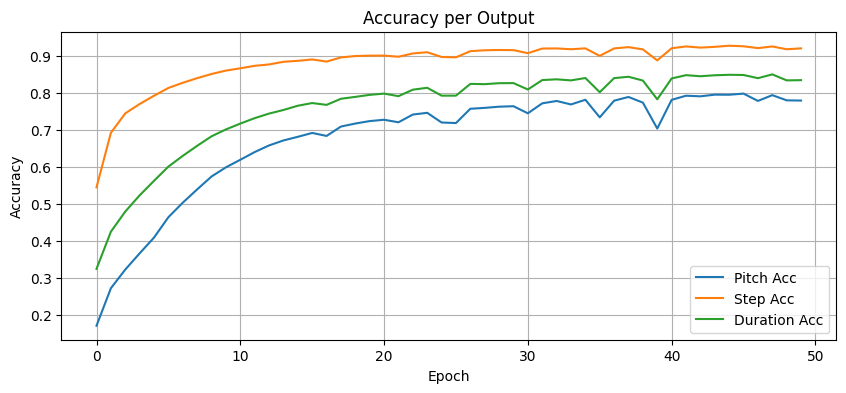

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# === Load processed data ===
X_list, y_list = [], []

for filename in os.listdir("processed_data_transformer"):
    if filename.endswith(".npz"):
        data = np.load(os.path.join("processed_data_transformer", filename))
        X_list.append(data["X"])
        y_list.append(data["y"])

X = np.concatenate(X_list, axis=0)  # shape: (num_samples, SEQ_LEN, 3)
y = np.concatenate(y_list, axis=0)  # shape: (num_samples, 3)

SEQ_LEN = X.shape[1]
INPUT_DIM = X.shape[2]

print(f"✅ Combined: X = {X.shape}, y = {y.shape}")

# === Split into train/val ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# === Build LSTM model with multi-output ===
inputs = Input(shape=(SEQ_LEN, INPUT_DIM))

x = LSTM(256, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = LSTM(256)(x)
x = Dropout(0.3)(x)

pitch_out = Dense(128, activation="softmax", name="pitch")(x)
step_out = Dense(100, activation="softmax", name="step")(x)
dur_out = Dense(100, activation="softmax", name="duration")(x)

model = Model(inputs=inputs, outputs={"pitch": pitch_out, "step": step_out, "duration": dur_out})

model.compile(
    optimizer="adam",
    loss={
        "pitch": "sparse_categorical_crossentropy",
        "step": "sparse_categorical_crossentropy",
        "duration": "sparse_categorical_crossentropy"
    },
    metrics={"pitch": "accuracy", "step": "accuracy", "duration": "accuracy"}
)

model.summary()

# === Save model checkpoints ===
os.makedirs("trained_model", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

checkpoint = ModelCheckpoint(
    "checkpoints/lstm_model_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# === Train model ===
history = model.fit(
    X_train,
    {
        "pitch": y_train[:, 0],
        "step": y_train[:, 1],
        "duration": y_train[:, 2]
    },
    validation_data=(X_val, {
        "pitch": y_val[:, 0],
        "step": y_val[:, 1],
        "duration": y_val[:, 2]
    }),
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint],
    verbose=1
)

# === Save final model ===
model.save("trained_model/lstm_music_model.keras")
print("✅ Final model saved.")

# === Plot accuracy ===
plt.figure(figsize=(10, 4))
plt.plot(history.history["pitch_accuracy"], label="Pitch Acc")
plt.plot(history.history["step_accuracy"], label="Step Acc")
plt.plot(history.history["duration_accuracy"], label="Duration Acc")
plt.title("Accuracy per Output")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(); plt.grid(); plt.show()


## 🎶 Generate New Music Using LSTM Model


In [9]:
import os
import numpy as np
import tensorflow as tf
import pretty_midi
import random
from glob import glob

# === Configuration ===
MODEL_PATH = "trained_model/lstm_music_model.keras"
DATA_FOLDER = "processed_data_transformer"
MIDI_FOLDER = "midi_input_music"
OUTPUT_FOLDER = "generated_music_lstm"
GENERATE_STEPS = 120
STEP_BINS = np.linspace(0, 1.0, 100)
DUR_BINS = np.linspace(0, 2.0, 100)

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
random.seed(42)
np.random.seed(42)

# === Load model ===
model = tf.keras.models.load_model(MODEL_PATH)
SEQ_LEN = model.input_shape[1]
INPUT_DIM = model.input_shape[2]
print(f"✅ Loaded LSTM model with SEQ_LEN={SEQ_LEN}, INPUT_DIM={INPUT_DIM}")

# === Convert bin index to real value ===
def bin_to_value(index, bins):
    index = int(np.clip(index, 0, len(bins) - 1))
    return bins[index]

# === Save generated MIDI ===
def save_to_midi(events, output_path, program=0):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)
    
    time = 0.0
    for pitch, step_bin, dur_bin in events:
        step = bin_to_value(step_bin, STEP_BINS)
        duration = bin_to_value(dur_bin, DUR_BINS)
        start = time + step
        end = start + duration
        note = pretty_midi.Note(velocity=100, pitch=int(pitch), start=start, end=end)
        instrument.notes.append(note)
        time = start

    pm.instruments.append(instrument)
    pm.write(output_path)
    print(f"🎵 Saved: {output_path}")

# === Generate sequence from seed ===
def generate_sequence_lstm(seed_tokens, model, steps=GENERATE_STEPS):
    generated = []
    sequence = seed_tokens.copy().astype(np.float32)

    for _ in range(steps):
        input_seq = sequence.reshape(1, SEQ_LEN, 3)
        preds = model.predict(input_seq, verbose=0)

        pitch = int(np.argmax(preds["pitch"][0]))
        step = int(np.argmax(preds["step"][0]))
        dur = int(np.argmax(preds["duration"][0]))

        generated.append((pitch, step, dur))

        sequence = np.roll(sequence, -1, axis=0)
        sequence[-1] = [pitch, step, dur]

    return generated

# === Find all MIDI files recursively ===
all_midi_paths = {os.path.splitext(os.path.basename(p))[0]: p for p in glob(os.path.join(MIDI_FOLDER, "**", "*.mid"), recursive=True)}

# === Main generation loop ===
for npz_file in sorted(os.listdir(DATA_FOLDER)):
    if not npz_file.endswith(".npz"):
        continue

    song_name = os.path.splitext(npz_file)[0]
    midi_path = all_midi_paths.get(song_name)
    if midi_path is None or not os.path.exists(midi_path):
        print(f"⚠️ Missing MIDI: {song_name}, skipping.")
        continue

    data = np.load(os.path.join(DATA_FOLDER, npz_file))
    X = data["X"]
    program = int(data["program"]) if "program" in data else 0

    if len(X) == 0:
        print(f"⚠️ Skipping {npz_file}: no data.")
        continue

    seed = X[-1]  # last sequence
    if seed.shape[0] < SEQ_LEN:
        pad_len = SEQ_LEN - seed.shape[0]
        seed = np.vstack([np.zeros((pad_len, 3)), seed])

    print(f"🎶 Generating music in the style of: {song_name}")
    events = generate_sequence_lstm(seed, model)

    output_path = os.path.join(OUTPUT_FOLDER, f"{song_name}_LSTM.mid")
    save_to_midi(events, output_path, program=program)


✅ Loaded LSTM model with SEQ_LEN=128, INPUT_DIM=3
⚠️ Missing MIDI: ..._Baby_One_More_Time, skipping.
🎶 Generating music in the style of: A_Big_Hunk_O_Love
🎵 Saved: generated_music_lstm\A_Big_Hunk_O_Love_LSTM.mid
🎶 Generating music in the style of: A_Campfire_Song
🎵 Saved: generated_music_lstm\A_Campfire_Song_LSTM.mid
🎶 Generating music in the style of: All_Mixed_Up.1
🎵 Saved: generated_music_lstm\All_Mixed_Up.1_LSTM.mid
🎶 Generating music in the style of: All_Mixed_Up
🎵 Saved: generated_music_lstm\All_Mixed_Up_LSTM.mid
🎶 Generating music in the style of: Andra_tutto_bene_58_.1
🎵 Saved: generated_music_lstm\Andra_tutto_bene_58_.1_LSTM.mid
🎶 Generating music in the style of: Andra_tutto_bene_58_
🎵 Saved: generated_music_lstm\Andra_tutto_bene_58__LSTM.mid
🎶 Generating music in the style of: Bad_Meets_Evil
🎵 Saved: generated_music_lstm\Bad_Meets_Evil_LSTM.mid
🎶 Generating music in the style of: Because_You_Loved_Me
🎵 Saved: generated_music_lstm\Because_You_Loved_Me_LSTM.mid
🎶 Generating mu